# Non-negative Matrix Factorization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state
import math

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(D, S) = \frac{1}{2}\|X-D S\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|S\|_{F}^{2}+\lambda\|S\|_{1}+\frac{\nu}{2}\|D\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
D \leftarrow D \circ \frac{X S^{\top}}{D (S S^{\top} + {\color{red} \nu I_r})} \\
S \leftarrow S \circ \frac{D^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(D^{\top} D + {\color{red} \mu I_r})S}
\end{array}

Fill in the following NMF class:

In [12]:
class MYNMF():
    
    def __init__(self, n_components, random_state=42, max_iter=200, loss = 'Frobenius', epsilon = 1e-6, regularized=False):
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.components_ = None    # shape (r, p)
        self.random_state = random_state
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.regularized_ = regularized
        
    def fit_transform(self, data, mu=1., lambd=1., nu=1.):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        data: (n, p) np.array
               Data matrix
        
        Returns:
        -----
        embedding: (n, r) np.array
                    Embedding matrix        
        """        
        X = data
        n, p = X.shape
        #initialize the components matrix
        D = np.random.rand(p, self.n_components_)
        #initialize the embedding matrix
        S = np.random.rand(self.n_components_, n)
        #initiliaze iterations (start from 1 to max_iter_ at maximum)
        iteration =1
        while (iteration<self.max_iter_) & (np.linalg.norm(X.T - D@S) > self.epsilon_) :
            
            if self.loss_ == 'Frobenius':
                if self.regularized_ :
                    D = D * ((X.T@S.T)/(D@(S@S.T+nu*np.identity(self.n_components_))))
                    S = S * (((D.T@X.T-lambd*np.ones((self.n_components_,n),dtype=int))/((D.T@D+mu*np.identity(self.n_components_))@S)))
                else:
                    D = D * ((X.T@S.T)/(D@S@S.T))
                    S = S * ((D.T@X.T)/(D.T@D@S))

            iteration+=1
        self.components_ = D.T  
        return S.T  
    
    
    def inverse_transform(self, embedding):
        """ Maps an embedding matrix into the original space. 
        
        Parameters:
        -----------
        embedding : (n, r) np.array
                     Embedding matrix
        
        Returns:
        -----
        data_hat : (n, p) np.array  
                   reconstructed data matrix
        """       
        # TODO

        return embedding@self.components_

    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
           data matrix
        
        Returns:
        -----
        label assignment : (n, ) np.array
                          Its elements are the predicted classes, from 0 to r-1
        """
        # TODO
        proba = self.predict_proba(X)
        labels = np.argmax(proba, axis=1)
        return labels
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assignment : (n, r) np.array
                          Its elements are the probabilities for different classes
        """
        # TODO
        from scipy.special import softmax
        
        new_embedding = self.fit_transform(X)
        proba = softmax(new_embedding, axis=1)
        
            
        return proba

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

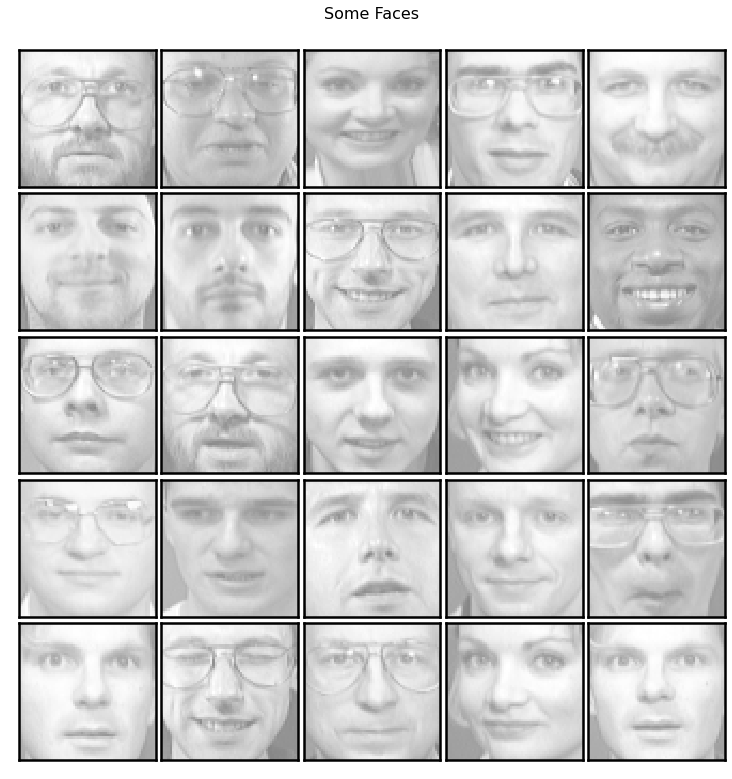

In [10]:
from sklearn.datasets import fetch_olivetti_faces


dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, title, cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = int(np.ceil(np.sqrt(n_images)))
    ncols = nrows
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    

plot_gallery(title="Some Faces", 
             images=faces[:25], 
             image_shape=image_shape)


Let's apply the nmf algorithm

In [13]:
#Apply the nmf algorithm
nmf = MYNMF(loss='Frobenius', n_components=18*18, epsilon=0.01, regularized=True)
embedding = nmf.fit_transform(data=faces)
approximated_faces = nmf.inverse_transform(embedding)

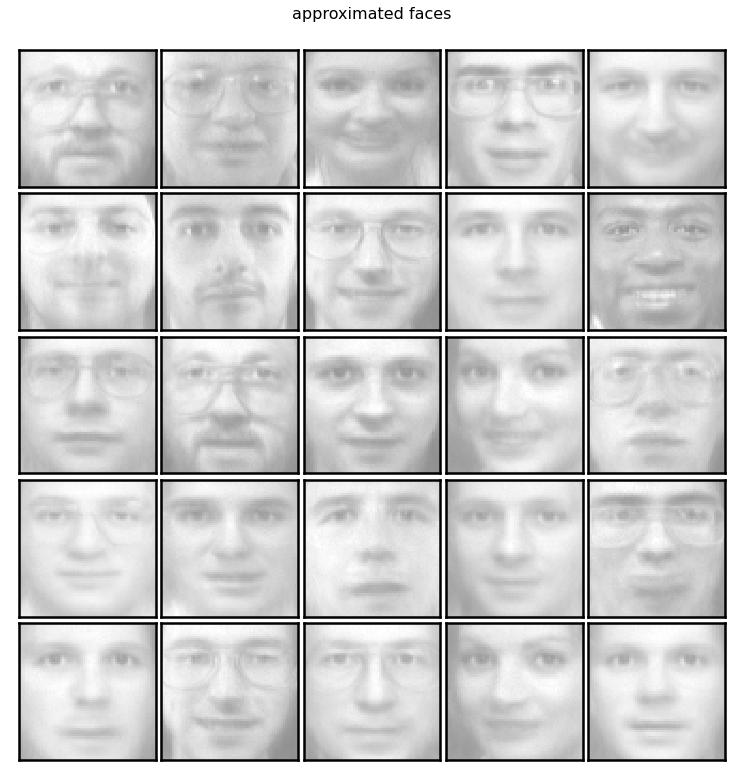

In [14]:
#plot the approximated faces
plot_gallery(title = 'approximated faces', images = approximated_faces[:25], image_shape = (64,64))

**Comment** <br>
We can clearly see that the "reconstructed" face images are visually pretty similar to the original face images.

### Parameter choice : number of components

#### How to deternmine the n_components (the unknown dimension in the embedding matrix) ?

We know that $$ r = n_{components} \leq min(n,p) $$
where: $$n = n_{samples} = 400$$
$$p = n_{features} = 4096 = 64*64$$

To determine what value of r to choose, we consider a list of candidate values of r :
$$ [50,70,90,..,370,390]$$
Initial value is 50 and we increment by 20 each next value until 390 < 400.

Then, for each value of $r$ we compute loss (the image reconstruction error).
We choose the lowest $r$ value before converging to a stable loss.

**NOTE** <br>
We didn't have time to tune the regularization parameters, so we kept the initial values of 1.0 for all parameters which might not be optimal. For a better model that generalizes better, we need to tune the n_components parameters along with the regularizations paramaters and find the best set of parameters that yields the lowest loss error.

In [16]:
#define the candidate values of n_components
r_candidates = [50 + 20*i for i in range(18)]
#list of losses to be filled with the loss of each n_component value
losses = []

for r in r_candidates:
    nmf = MYNMF(loss='Frobenius', n_components=r, epsilon=0.01, regularized=True)
    embed = nmf.fit_transform(faces)
    losses.append(np.linalg.norm(faces - nmf.inverse_transform(embed)))

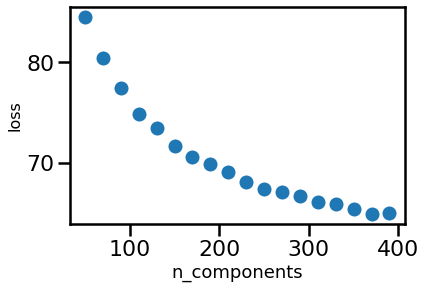

In [17]:
#plot losses variation over n_components values
fig = plt.figure()
plt.scatter(r_candidates, losses)
plt.xlabel('n_components', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.show()

**n_components = 324 = 18*18** seems to be a reasonable choice, plus it's a square number so it will be helpful for the next plot in a $(\sqrt{r}, \sqrt{r})$ grid.

## Interpretation of both factor matrices

### 1. The components  Matrix 

In [18]:
#Apply the nmf algorithm
nmf = MYNMF(loss='Frobenius', n_components=18*18, epsilon=0.01)
embedding = nmf.fit_transform(data=faces)

Plot the components matrix in a $(\sqrt{r}, \sqrt{r})$ grid

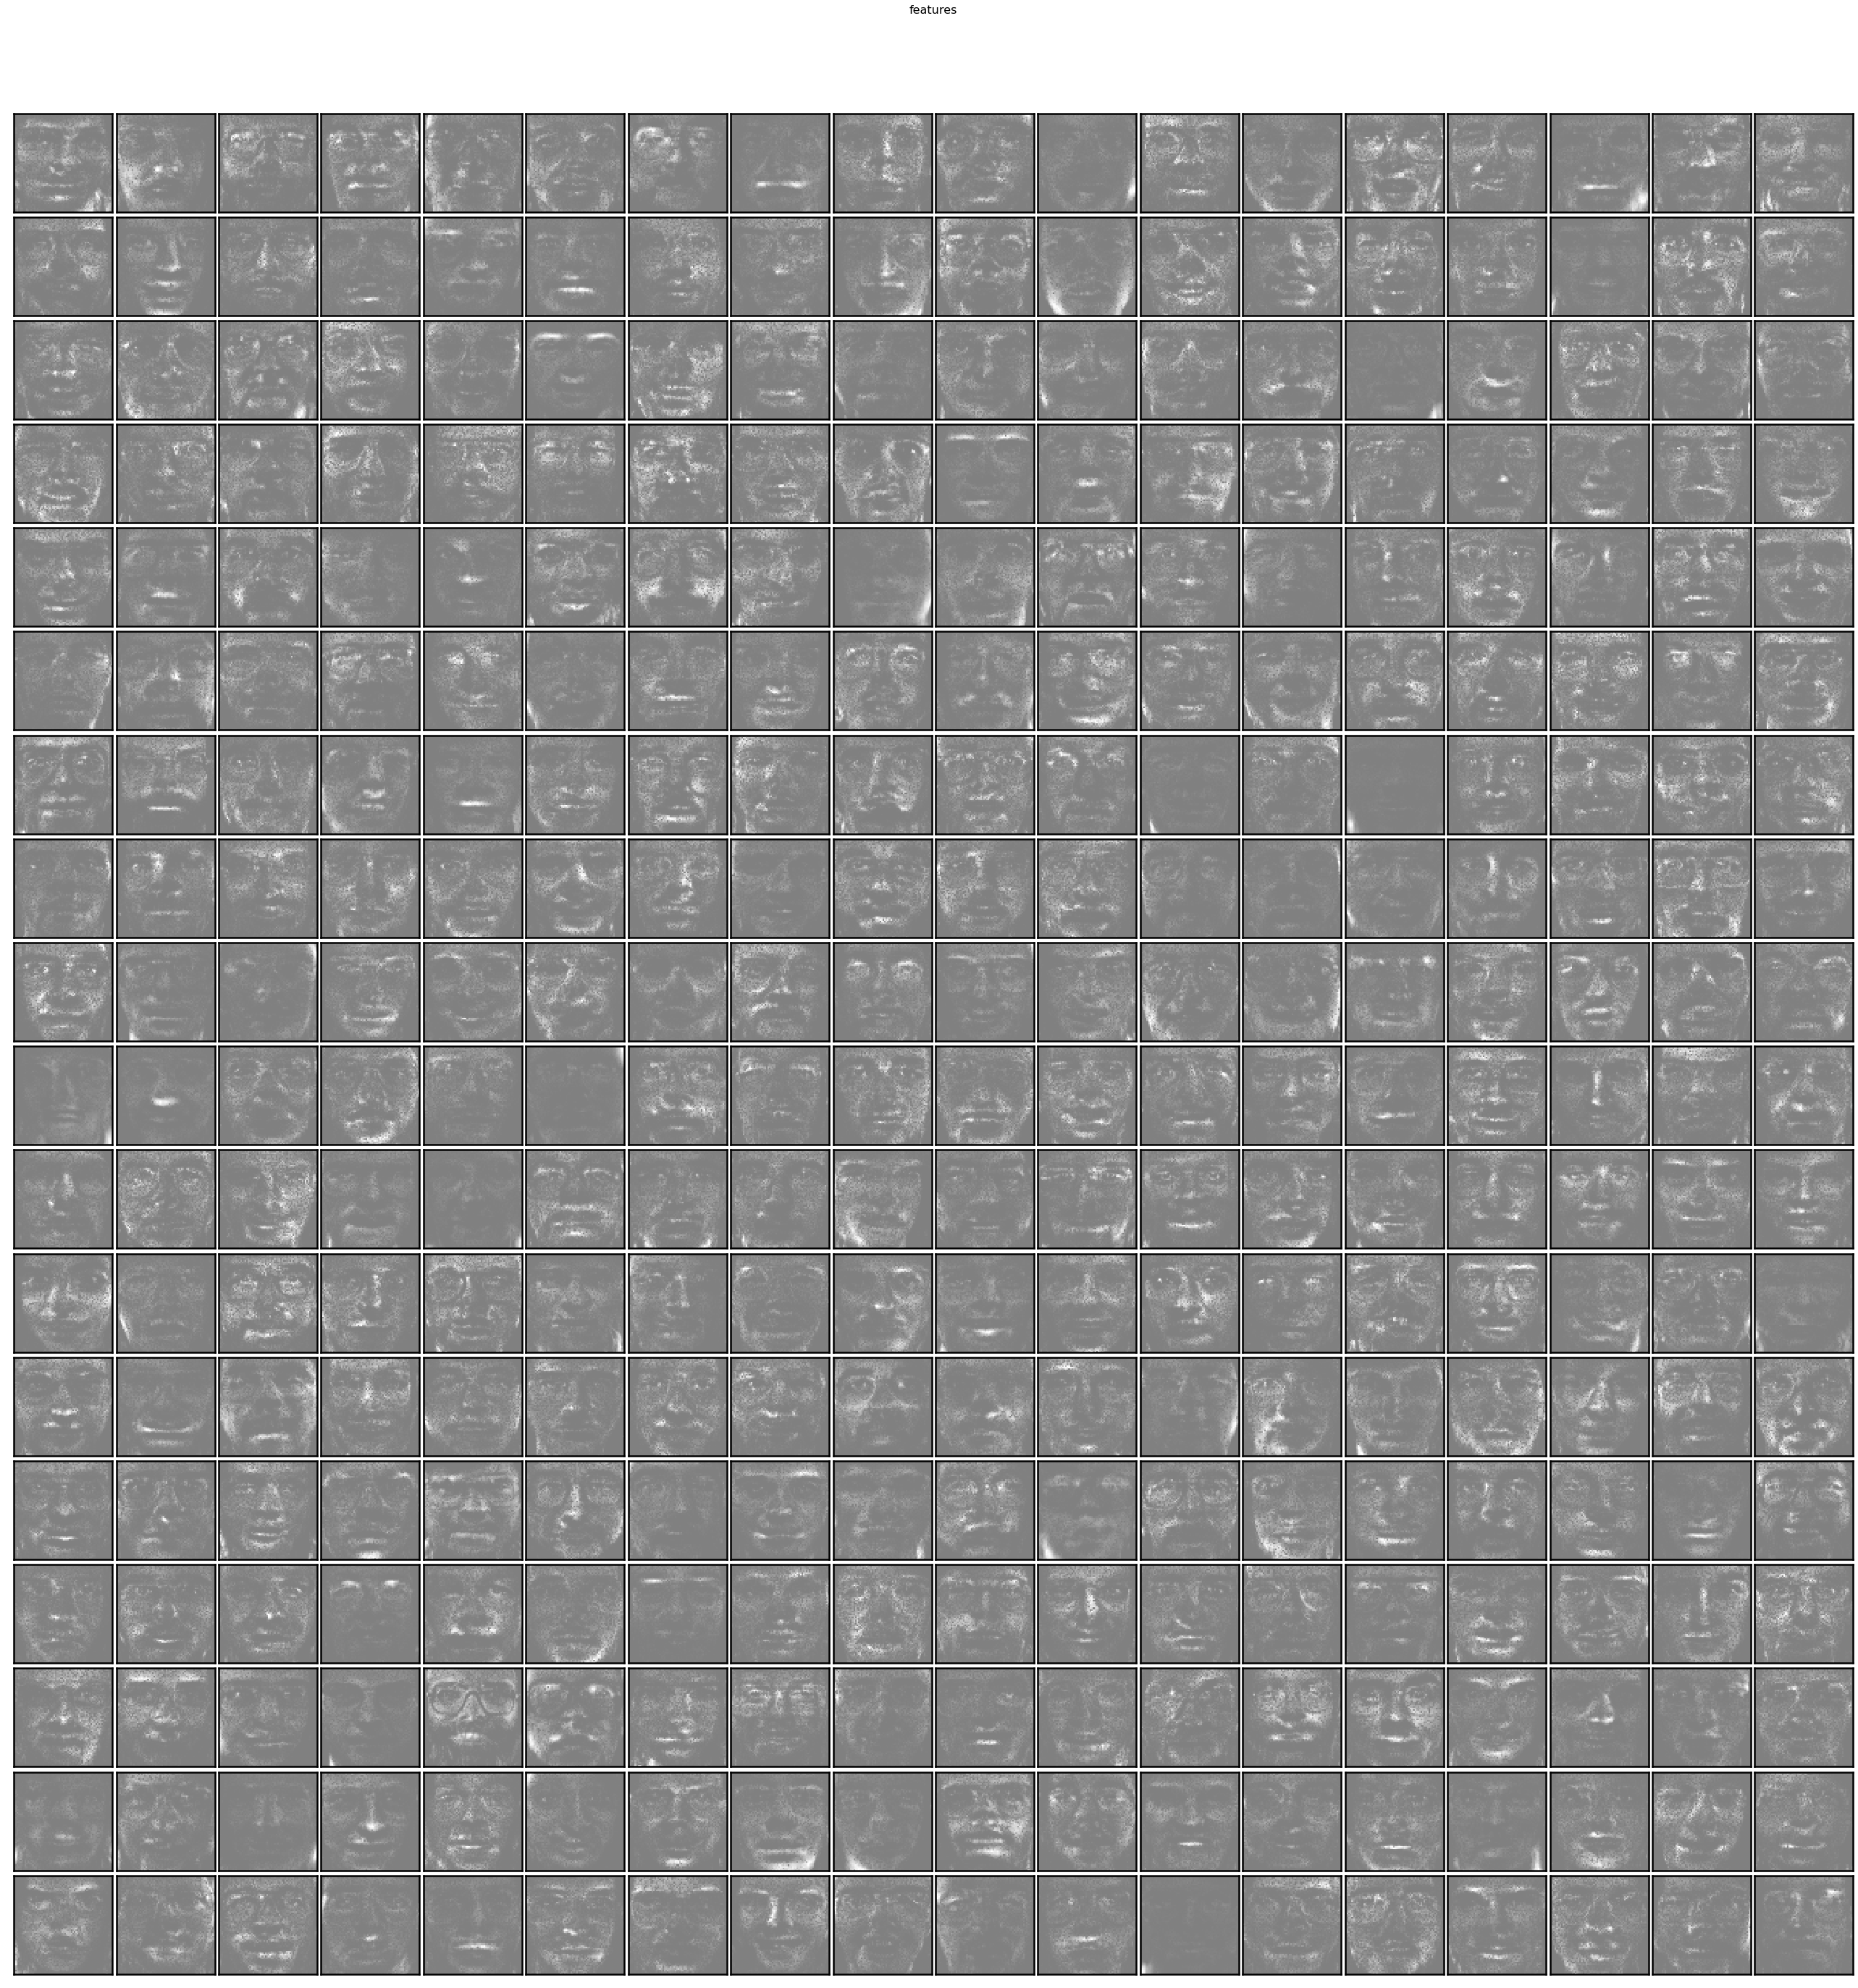

In [19]:
plot_gallery(nmf.components_, image_shape, title = 'features', cmap=plt.cm.gray)    

**Comment**
- By plotting the component matrix, we can see that it represents facial features learned from the faces data used for fitting.
- For each image, these features are present with different weights. In other words, each facial image is a weighted sum of these facial features (the weight denotes the importance of the correspondant facial feature in the facial image)

### 2. The embedding matrix

Plot the embedding matrix in a $(\sqrt{r}, \sqrt{r})$ grid as well.
We will do that for one image.
We can choose the first face image for example (index=0) which corresponds to the first row in the embedding matrix.

In [20]:
embedding_0 = embedding[0,:]
embedding_0 = embedding_0.reshape((18*18,1))
embedding_0 = embedding_0.reshape((18,18))

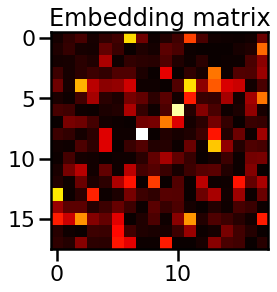

In [21]:
plt.imshow(embedding_0, cmap='hot', interpolation='nearest')
plt.title('Embedding matrix')
plt.show()

**Comment** : <br>
The Embedding matrix represents the weight or degree of importance of features. which means :
- A dark hot color means a hight importance of the correspandant feature in the image.
- A light color means a low importance of the correspondant feature in the image.

To Conclude, the matrix decomposition can be formulated as follows : 
$$X[:,j]\ \approx \sum_{k=1}^{r} Components[:,k].Embeddings[k,j]\ $$
Where: <br>
- $X[:,j]$   : represents the $j^{th}$ image<br>
- $Components[:,k]$   : represents the facial features<br>
- $Embeddings[k,j]$   : represents the importance degree of features in $j^{th}$ image<br>


### 3. Vizualize predictions

To understand more what we have explained before on the meaning of Components and Embeddings matrices, we will plot predicted labels  of some images from the faces dataset. <br>  
By predicted label we mean the facial feature with the highest presence/importance to the correspondant image.

In [23]:
#predict the label of each facial image : label is (n, ) np.array and its elements are the predicted classes, from 0 to (n_components -1)
labels = nmf.predict_label(faces)

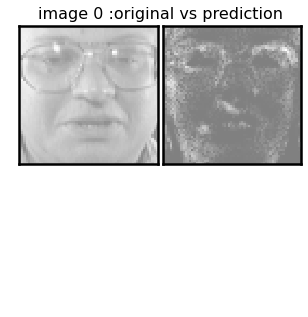

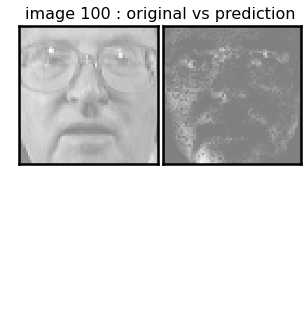

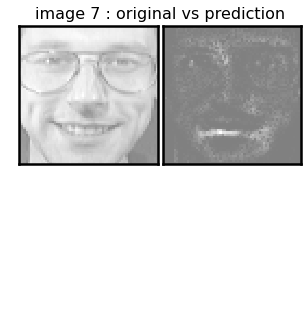

In [24]:
plot_gallery(title="image 0 :original vs prediction", 
             images=np.array([faces[1,:],nmf.components_[labels[1],:]]), 
             image_shape=image_shape)

plot_gallery(title="image 100 : original vs prediction", 
             images=np.array([faces[150,:],nmf.components_[labels[150],:]]), 
             image_shape=image_shape)

plot_gallery(title="image 7 : original vs prediction", 
             images=np.array([faces[7,:],nmf.components_[labels[7],:]]), 
             image_shape=image_shape)

**Comment** <br>
We can see that the predicted label (the most important feature) are pretty similar to the original image. So The NMF captures very well the important features in images. <br>
    Here we can not tell if the model has a good testing performance or not because we tested on images that were used by the NMF model for fitting tranformation. <br>
    To check if the nmf model generalizes well, we should split the facial images into training images and testing images (80% / 20% split for example). Then we only fit the model on training images and after we check check if the nmf fitted model makes good predictions on testing (unseen) data. If not, the model is overfitting, and we can solve that by adding more training images or tuning the parameters.

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model, print top words
# TODO
from sklearn.decomposition import NMF
model = NMF(n_components=n_components, init='random', random_state=0)
model.fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(model.components_.T, tfidf_feature_names, n_top_words)


Topic #0: just people don like know say time ve right really did make way got want sure said ll things going
Topic #1: key chip government clipper encryption keys use public law enforcement secure phone data nsa used security communications clinton going standard
Topic #2: thanks know does mail advance hi info interested anybody email looking like help appreciated card information list send need post
Topic #3: windows file dos use using program window files problem help os application running drivers version ms screen ftp work available
Topic #4: edu soon com send university internet ftp mail mit information article pub cc address email hope mac blood contact program
Topic #5: car new 00 bike 10 price good cars sale power space year engine condition miles used cost buy years insurance
Topic #6: drive drives hard card disk software floppy pc mac apple computer power scsi controller memory problem monitor board mb video
Topic #7: game team year games play win season players nhl runs ll f

***
If we want to interpert more clearly this result into 'single-word topics' we might say that the recurrent topics found by the NMF embedding method relate more generally to:

*religion*, *science*, *sports*, *law and politics*, *sales*, *Technology* ... 

So this Topic modeling Method was atually useful for giving us insight into the main topics covered by the documnts in the 20newsgroups dataset (even if it was trained just on a sample), in fact we can in a way verify how well this model performed by looking at the given label names which are included in the data set: 

In [5]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

#### How the model acts on unseen samples

***

With which topics does the nmf model best associate a new sample? Does it make sense? What about another new sample?

***

In [6]:
new_data_sample = dataset.data[2036]  # unseen
print(new_data_sample)
tfidf_new = tfidf_vectorizer.transform(list(new_data_sample))
transformed = model.components_@tfidf_new.T
print_top_words(transformed.T, tfidf_feature_names, n_top_words)


Didn't Paul write that if the Resurrection is not true, we are the
biggest fools of all?  However, whether you believe in Christ or not,
His teachings (e.g. love your brotherman as yourself), even if only 
followed at a secular level, could do a great deal to alleviate some of 
the problems we see today in the world.  Even when I was a rabid atheist 
I couldn't deny that.
Topic #0: fit attempt army article ask asked asking assume atheism attack attacks au basically author authority automatic available average away azerbaijan
Topic #1: fit attempt army article ask asked asking assume atheism attack attacks au basically author authority automatic available average away azerbaijan
Topic #2: fit attempt army article ask asked asking assume atheism attack attacks au basically author authority automatic available average away azerbaijan
Topic #3: fit attempt army article ask asked asking assume atheism attack attacks au basically author authority automatic available average away azerbaijan


Topic found for this single element sample : *"fit attempt army article ask asked asking assume atheism attack attacks au basically author authority automatic available average away azerbaijan"*  Which is closest to the "religion" topic found in the dictionnary of topics as seen above. 
This is quite coherent with the content of the original text of the sample and is well adapted to the top topics found in the NMF dictionnry matrix. 
So the pre-trained performed quite well on this unseen data point.

Let's try another Random sample! 

In [7]:
new_data_sample_2 = dataset.data[11000]  # unseen
print(new_data_sample_2)
tfidf_new_2 = tfidf_vectorizer.transform(list(new_data_sample_2))
transformed_2 = model.components_@tfidf_new_2.T
print_top_words(transformed_2.T, tfidf_feature_names, n_top_words)



I couldnt agree more.  That is how it SHOULD work. People should also ALWAYS see motorcycles too.

I CONSTANTLY scan behind me (I have one of those wink mirrors) and two outside mirrors.  I actually spend just as much time checking my six (cops you know).

I still get caught off guard every now and then. 

Topic #0: dollars apply anti anybody apartment appears apple application applications appreciated argument approach appropriate apr april archive area areas answers answer
Topic #1: dollars apply anti anybody apartment appears apple application applications appreciated argument approach appropriate apr april archive area areas answers answer
Topic #2: dollars apply anti anybody apartment appears apple application applications appreciated argument approach appropriate apr april archive area areas answers answer
Topic #3: dollars apply anti anybody apartment appears apple application applications appreciated argument approach appropriate apr april archive area areas answers answer
To

This second example of unseen data, doesn't unfortunately make much sense as a "topic" and is quite far from the fitted model's dictionnary matrix top topics, as well as the text subject itself (which is relating to motorcycles or sports more generally)  

In conclusion, We cannot be sure of how well the model would perform on an unseen document of the dataset, The sample we took (2000 data points) is not quite representative of the whole set with the size of ~18000 points, even if we shuffled. 
So if it is faced by a quite new set of words it will not be easily able to extract the most important feature to describe a topic. 

#### NMF and other NLP methods

***
How does this NMF method compare to other embedding methods you know in NLP?
***

The task at hand in this second application of NMF is Topic Modeling, We have a number of documents and we are trying to find the top topics they might cover (the more recurring topics). Known NLP methods for this exact task are

* LSA, Latent Semantic Analysis 
* And LDA, Latent Dirichlet Allocation 

Let's try and compare the NMF model results, to those obtained by an LDA model, available also in the sklearn library

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)
lda_model.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [9]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_model.components_.T, tf_feature_names, n_top_words)

Topic #0: hiv health aids disease medical care study research said 1993 national april service children test information rules page new dr
Topic #1: drive car disk hard drives game power speed card just like good controller new year bios rom better team got
Topic #2: edu com mail windows file send graphics use version ftp pc thanks available program help files using software time know
Topic #3: vs gm thanks win interested copies john email text st mail copy hi new book division edu buying advance know
Topic #4: performance wanted robert speed couldn math ok change address include organization mr science major university internet edu computer driver kept
Topic #5: space scsi earth moon surface probe lunar orbit mission nasa launch science mars energy bit printer spacecraft probes sci solar
Topic #6: israel 000 section turkish military armenian greek killed state armenians people population attacks women israeli men weapon division dangerous jews
Topic #7: 10 55 11 15 18 12 20 00 13 93 1

Both The NMF and LDA models produce coherent results, That make some kind of a sense, giving us insight into what the recurrent topic of the documents of the sample may be. Even if not exactly the same, They do present similarities. *(science, sports, religion and politics subjects de resuface) 

One major differnece between these two topic modelling algorithms is time complexity: which is **Polynomial** in NMF, whare as for LDA the time complexity is proportional to **(n_samples * iterations)**